# Clustering

## Run following clustering algorithms for given fonts
1. K-Means
1. Spectral Clustering
1. Agglomerative
1. Mapper - from homework problem - if time permits

## Imports and Globals

In [1]:
from collections import namedtuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE

import font_utils.load_font as LF
import font_utils.upper_lower_numerals as ULN
import plot_utils.plot_font as PU
import plot_utils.plot_clusters as PLOT_CLUST
import sci_kit_learn_utils.clustering as CLUST

## Named Tuples
1. Font Selection
    1. Selected Font
    1. Font Variant Name
    1. Font Style
1. Plot Configuration
    1. Cluster Id
    1. Color
    1. Class Name

In [2]:
FontSelection = namedtuple('FontSelection', ['name', 'variant', 'style'])

FONTS = [
    FontSelection('garamond', 'GARAMOND', 'Old Style'),
    FontSelection('baskerville', 'BASKERVILLE OLD FACE', 'Transitional'),
    FontSelection('bodoni', 'BODONI', 'Modern'),
    FontSelection('arial', 'ARIAL', 'Sans Serif')
]

### Prepare Data
1. Get Upper/Lower/Numeral ASCII Code object
1. Load raw font data from disk
    1. Contains multiple faces for font
    1. Contains italic faces for font
    1. Contains normal weight and bold weight font
    1. Select only normal and bold weight
1. Capture array of lables
1. Pack Dimensionally Reduced DataFrames into list
1. Create ClusterUtility object
1. Create PlotCluster object

In [3]:
uln = ULN.UpperLowerNumerals.get_ascii_codes()

lf = LF.LoadFont('garamond')
font_dict = lf.get_trimmed_font()
font_df = font_dict['GARAMOND']['df']

LABEL_AR = None

raw_dfs = list()

for i in range(font_dict['GARAMOND']['min_char_count']):
        t_df = pd.DataFrame(data=[font_df.loc[font_df.m_label == x].iloc[i] for x in uln])
        
        if i==0:
            LABEL_AR = [chr(x) for x in t_df.m_label]
            
        t_df = t_df.drop(columns=['m_label'])
        t_df = t_df-t_df.mean(axis=0)
        
        pca = PCA(n_components=20)
        pca.fit(t_df)
        
        x = t_df.dot(pca.components_[0])
        y = t_df.dot(pca.components_[1])
        
        cluster_df = pd.DataFrame([x.transpose(), y.transpose()]).transpose()
        cluster_df.columns=['x','y']
        
        raw_dfs.append(cluster_df)
        
clust = CLUST.ClusterUtils()
plot_clust = PLOT_CLUST.PlotClusters(LABEL_AR)

### Call Each Clustering Method For Each Font Face
1. Font Faces
    1. Normal Weight
    1. Bold Weight
1. K-Means
1. Spectral Clustering
1. Agglomerative 

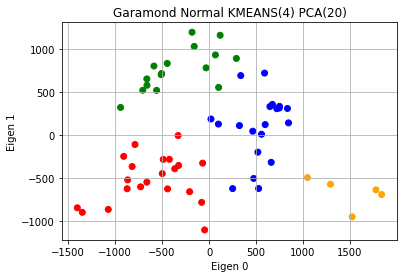

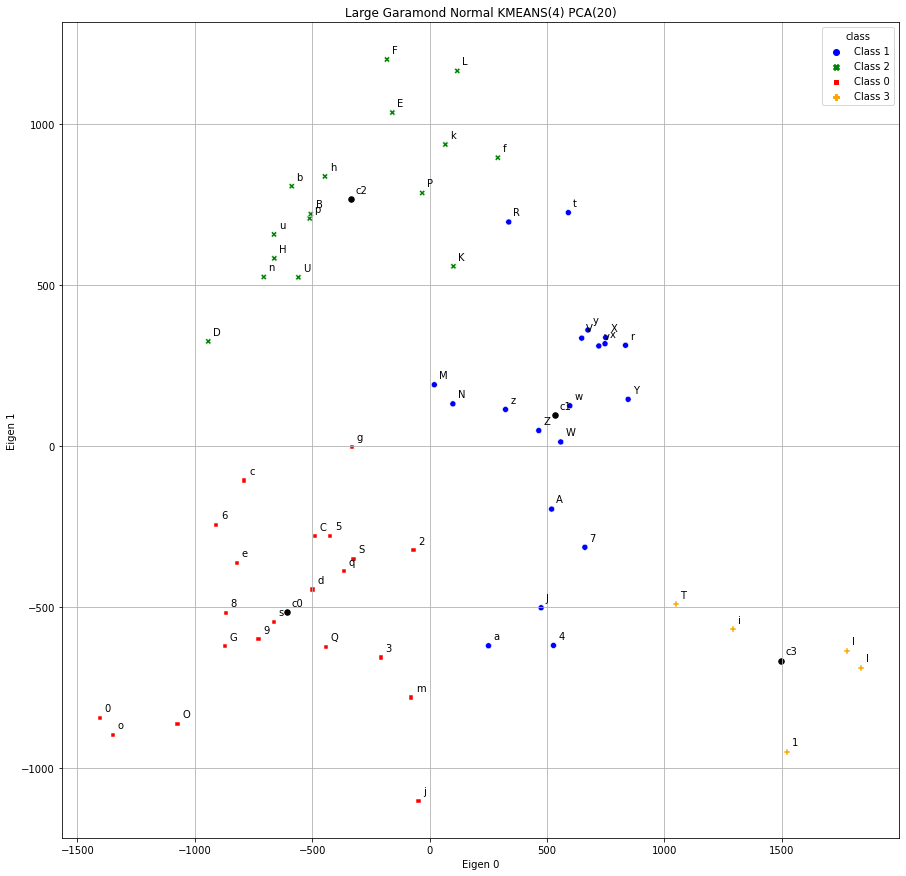

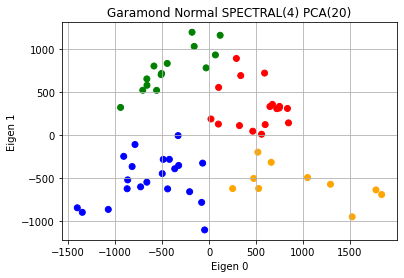

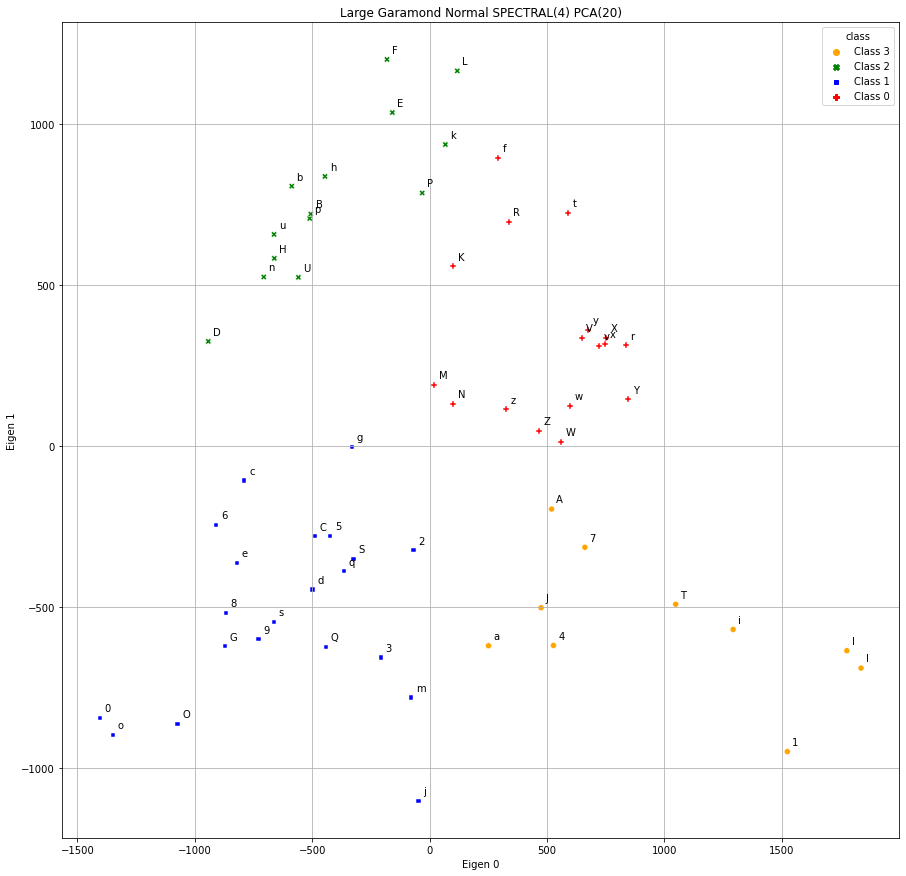

/home/digital-tenebrist/.conda/envs/math-637/lib/python3.7/site-packages/sklearn/cluster/_agglomerative.py:247: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  affinity='euclidean')


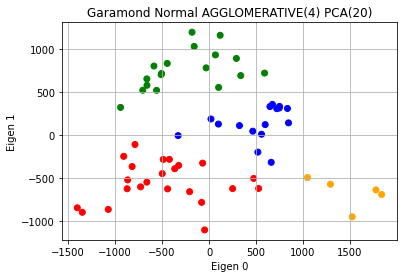

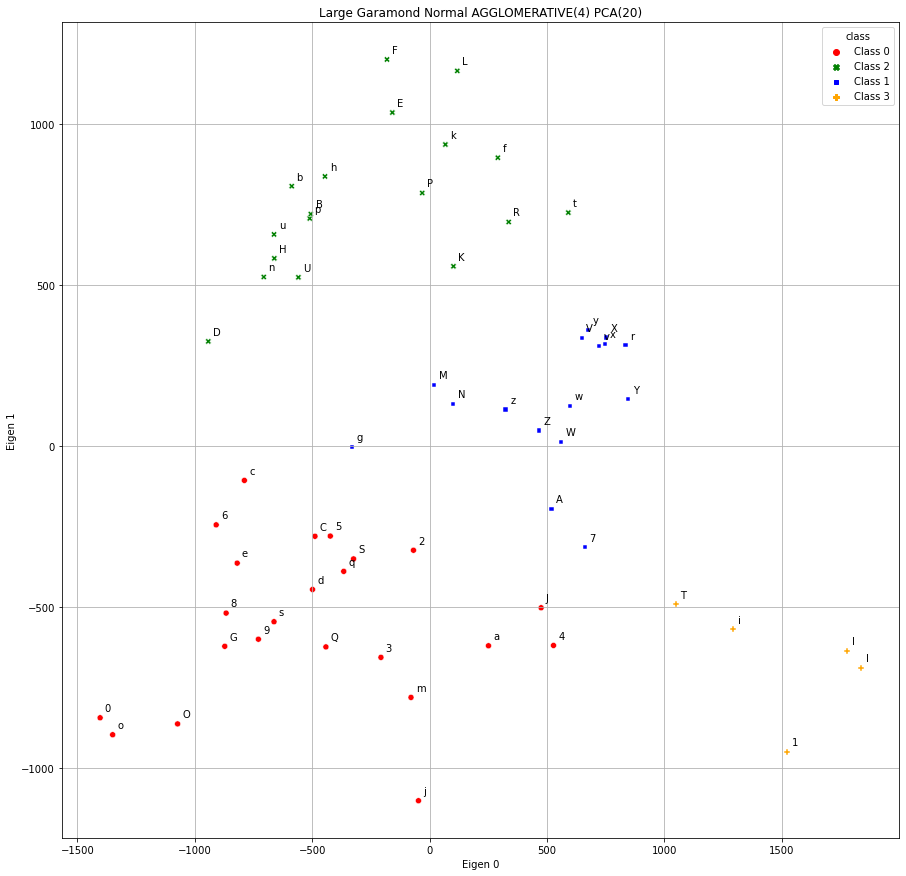

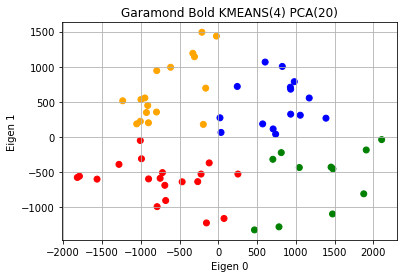

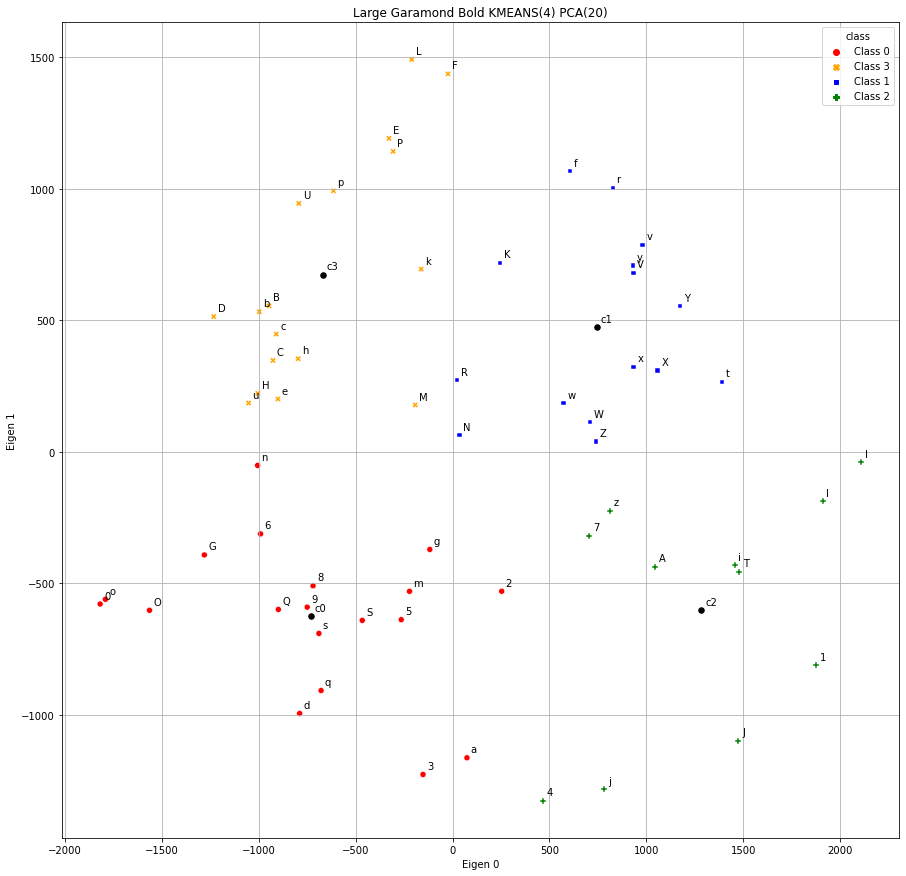

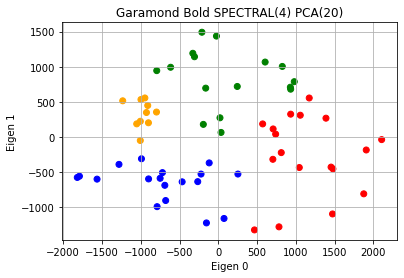

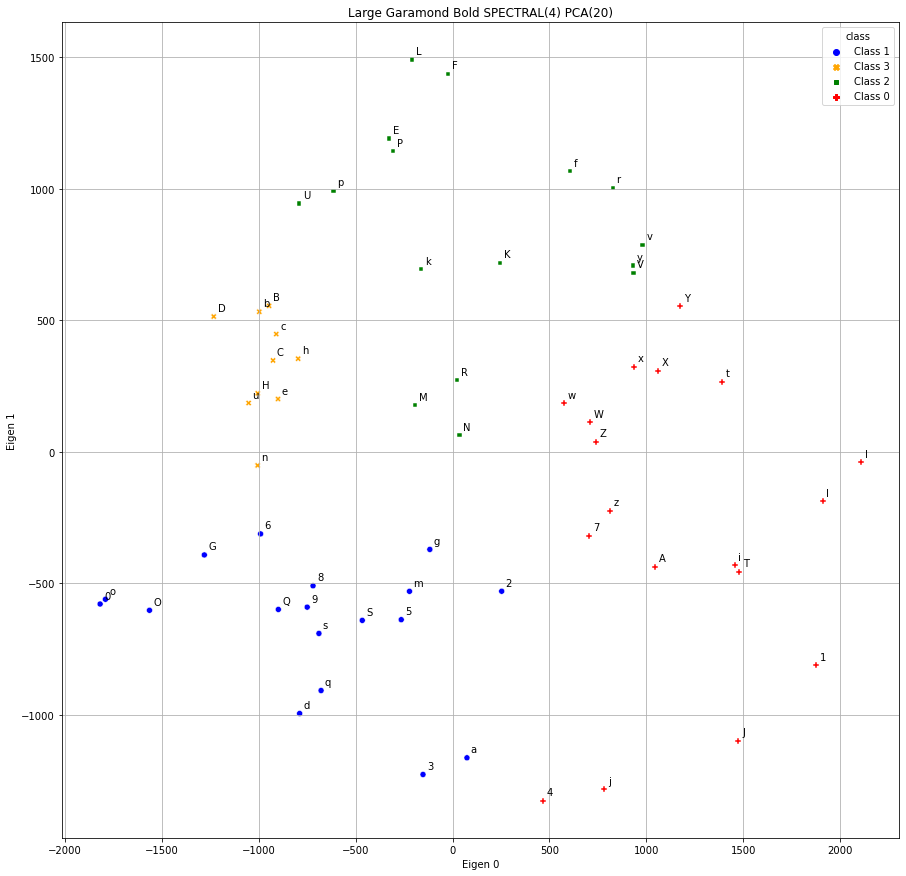

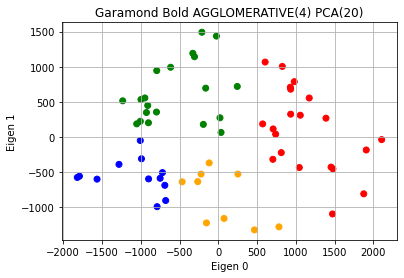

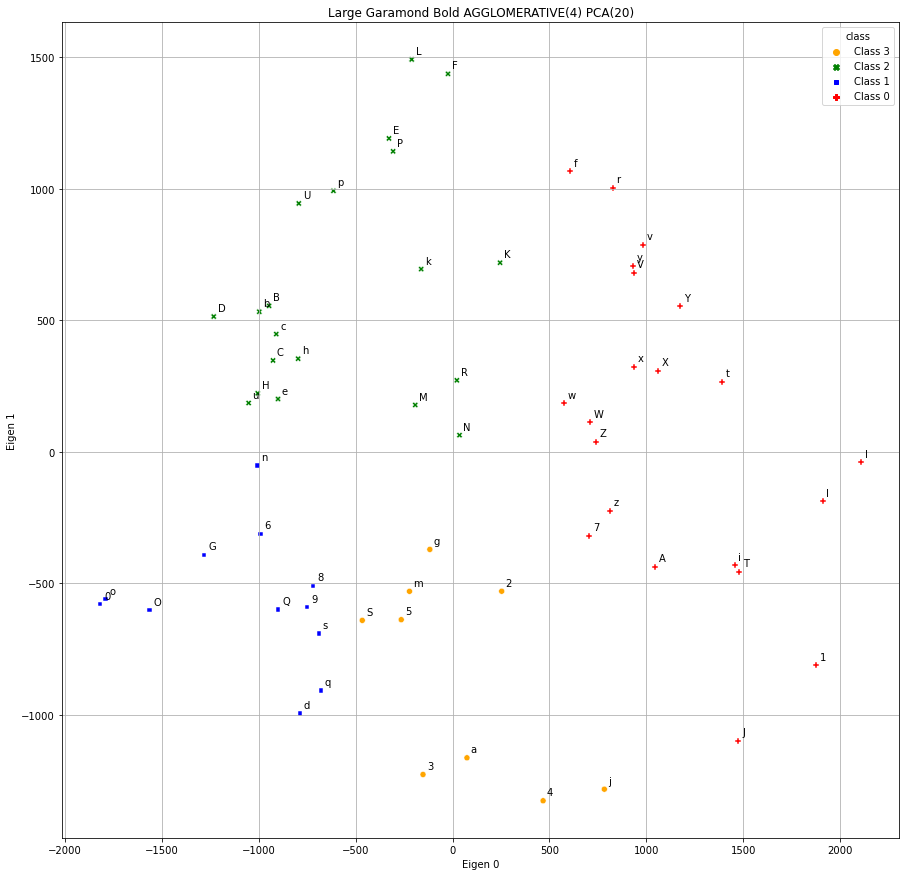

In [4]:
weight = ['Normal', 'Bold']
wt_idx=0

for df in raw_dfs:
    wt_str = weight[wt_idx]
    for m in ['kmeans', 'spectral', 'agglomerative']:
        sm_title = f'Garamond {wt_str} {m.upper()}(4) PCA(20)'
        lg_title = 'Large ' + sm_title
        clust_results = clust.perform_clustering(m, df)
        plot_clust.small_plot(df, clust_results['labels'], sm_title)
        plot_clust.large_plot(df, clust_results['labels'], lg_title, clust_results['centers'])
    wt_idx+=1